### Library Imports

In [7]:
# Supress Warnings
import warnings
import pickle
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Data Science
import numpy as np
import pandas as pd

# Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Machine Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, ConvLSTM2D, BatchNormalization
import tensorflow as tf
import keras

# Planetary Computer Tools
import pystac_client
from odc.stac import stac_load
import planetary_computer as pc
pc.settings.set_subscription_key('58d635c0d3194d65b98b857cf6966e7f')

# Others
from itertools import cycle
from tqdm import tqdm   
import joblib
from sklearn.model_selection import KFold, cross_val_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
tqdm.pandas()

### Functions

In [216]:
# Process datasets to be uniform in the number of timsteps and pixels per sample 
def reshapeData3D(dataset, pixel, instances):
    dataset_reshaped1 = []
    for i in dataset:
        if i.shape[2] > pixel and i.shape[1] > pixel:
            dataset_reshaped1.append(i[:,:(pixel-i.shape[1]),:(pixel-i.shape[2])])
        elif i.shape[1] > pixel:
            dataset_reshaped1.append(i[:,:(pixel-i.shape[1]),:])
        elif i.shape[2] > pixel:
            dataset_reshaped1.append(i[:,:,:(pixel-i.shape[2])])
        else:
            dataset_reshaped1.append(i)

    dataset_reshaped = []
    for i in dataset_reshaped1:
        if i.shape[0] >instances:
            dataset_reshaped.append(i[:instances,:,:])
        else:
            dataset_reshaped.append((i[:,:,:]))
    return [np.transpose(i) for i in dataset_reshaped]

In [217]:
# Opens pickled data from scraped files
def read_file(month):
    with open(f'{month}.pkl', 'rb') as file:
        return pickle.load(file)

In [218]:
# Extracts data for each sample from time_of_interest, coordinates, and boxsize/resolution
def getData(time_of_interest, lat_long, box_size_deg, resolution):
    latlong=lat_long.replace('(','').replace(')','').replace(' ','').split(',')
    bbox = (float(latlong[1])-box_size_deg/2, float(latlong[0])-box_size_deg/2, float(latlong[1])+box_size_deg/2, float(latlong[0])+box_size_deg/2)
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace)
    search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox, datetime=time_of_interest)
    items = list(search.get_all_items())
    scale = resolution / 111320.0 
    data = stac_load(items,bands=["vv", 'vh'], patch_url=pc.sign, bbox=bbox, crs="EPSG:4326", resolution=scale)
    VV = np.array(data.vv)
    VH = np.array(data.vh)
    return VV, VH

### Data Collection (Deployed on Microsoft Planetary Computer)

In [219]:
# Extract coordinate samples from training and test sets
df = list(pd.read_csv('Crop_Location_Data.csv')['Latitude and Longitude'])
df2 = list(pd.read_csv('challenge_1_submission_template.csv')['id'])

#Set coordinates for data scraping
coordinates = df + df2
# Yields 24 timesteps of the same sample
time_of_interest = "2022-04-01/2022-08-31" 
#Yields a closeup, 90x90 pixel image per sample
box_size_deg = 0.008 
resolution = 10 

#Scraping data from planetary computer
VV, VH = [], []
for i in coordinates:
    vv, vh = getData(time_of_interest, i, box_size_deg, resolution)
    VV.append(vv)
    VH.append(vh)
    print(len(VH))

#Saving data from planetary computer into pickle files as lists
with open("APR-AUG_VV.pkl", 'wb') as save:
    pickle.dump(VV, save)
with open("APR-AUG_VH.pkl", 'wb') as save:
    pickle.dump(VH, save)

### Initial Data Analysis

In [220]:
#Standardising the shape of VV and VH data samples
VH = reshapeData3D(read_file('APR-AUG_VH'), 90, 24)
VV = reshapeData3D(read_file('APR-AUG_VV'), 90, 24)

VH_mean = [np.mean(i) for i in VH]
VV_mean = [np.mean(i) for i in VV]

time_series_VH = [i.reshape(24,90,90) for i in VH[:600]]
time_series_VV = [i.reshape(24,90,90) for i in VV[:600]]

<Axes: xlabel='index', ylabel='VV'>

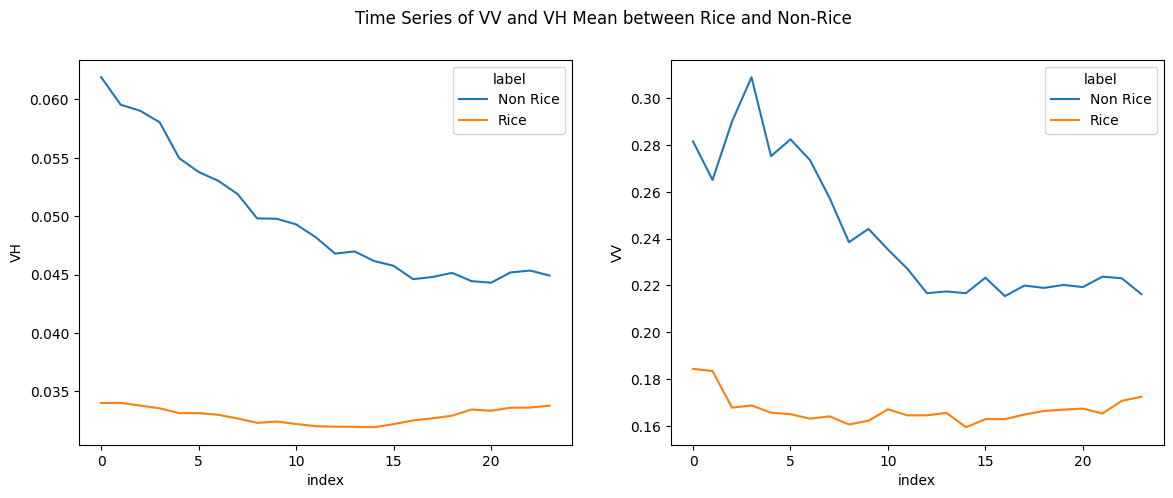

In [221]:
#Transforming VH tensors into mean VV over time stratified by rice and non-rice
VH_ls = []
for sample in time_series_VH:
    VH_list_series = []
    for timestep in sample:
        VH_list_series.append(np.mean(timestep))
    VH_ls.append(VH_list_series)

VH_ts = pd.DataFrame(VH_ls)
VH_ts['label'] = pd.read_csv('Crop_Location_Data.csv')['Class of Land']
VH_ts_rice = pd.DataFrame(VH_ts[VH_ts['label'] == 'Rice'].mean(), columns=['VH'])
VH_ts_rice['label'] = 'Rice'
VH_ts_non_rice = pd.DataFrame(VH_ts[VH_ts['label'] == 'Non Rice'].mean(), columns=['VH'])
VH_ts_non_rice['label'] = 'Non Rice'
VH_ts = pd.concat([VH_ts_non_rice, VH_ts_rice], axis=0).reset_index()

#Transforming VV tensors into mean VV over time stratified by rice and non-rice
VV_ls = []
for sample in time_series_VV:
    VV_list_series = []
    for timestep in sample:
        VV_list_series.append(np.mean(timestep))
    VV_ls.append(VV_list_series)

VV_ts = pd.DataFrame(VV_ls)
VV_ts['label'] = pd.read_csv('Crop_Location_Data.csv')['Class of Land']
VV_ts_rice = pd.DataFrame(VV_ts[VV_ts['label'] == 'Rice'].mean(), columns=['VV'])
VV_ts_rice['label'] = 'Rice'
VV_ts_non_rice = pd.DataFrame(VV_ts[VV_ts['label'] == 'Non Rice'].mean(), columns=['VV'])
VV_ts_non_rice['label'] = 'Non Rice'
VV_ts = pd.concat([VV_ts_non_rice, VV_ts_rice], axis=0).reset_index()


#Plotting the VV and VH time series
fig, axs = plt.subplots(ncols=2, figsize=(14, 5))
fig.suptitle("Time Series of VV and VH Mean between Rice and Non-Rice")
sns.lineplot(data=VH_ts, hue='label', y='VH', x='index', ax=axs[0])
sns.lineplot(data=VV_ts, hue='label', y='VV', x='index', ax=axs[1])


From a time series perspective, both VV and VH aggregates stratified by the labels exhibits linearly seperable fluctuatons.

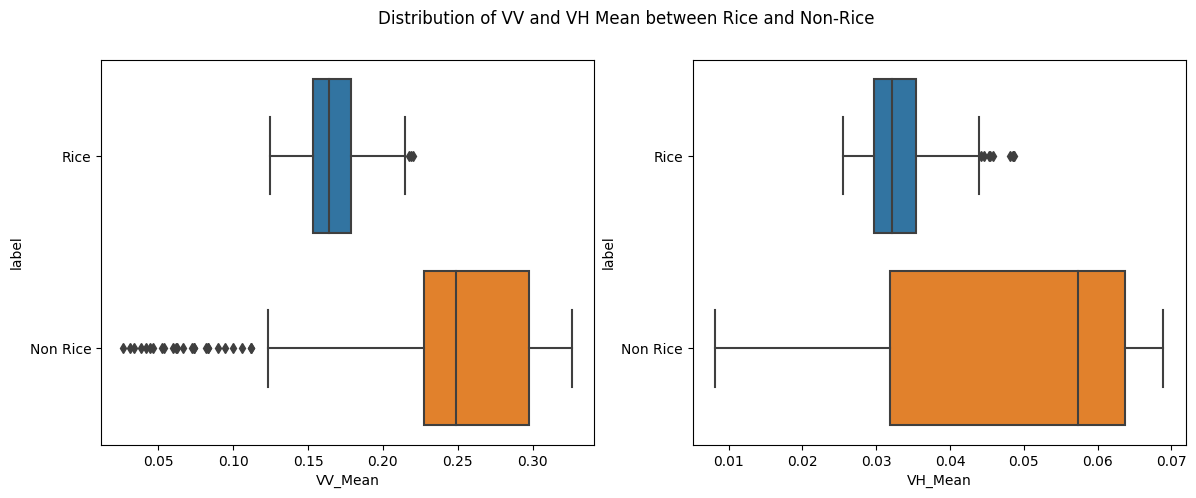

In [222]:
#Creating dataframe of aggregate VV/VH means stratified by labels
ida_df = pd.DataFrame()
ida_df['VH_Mean'] = VH_mean[:600]
ida_df['VV_Mean'] = VV_mean[:600]
ida_df['label'] = pd.read_csv('Crop_Location_Data.csv')['Class of Land']


#Plotting the VV and VH distributions
fig, axs = plt.subplots(ncols=2, figsize=(14, 5))

sns.boxplot(x=ida_df['VV_Mean'], y=ida_df['label'], ax=axs[0])
sns.boxplot(x=ida_df['VH_Mean'], y=ida_df['label'], ax=axs[1])

fig.suptitle("Distribution of VV and VH Mean between Rice and Non-Rice")
plt.show()

From a spatial perspective, both VV and VH distributions stratified by the labels exhibits a less variance for rice fields in contrast to non-rice fields.

### Preprocessing

In [223]:
#Performing matrix calculations to derive the RGB values for each sample
RGB = []
for i in range(len(VV)):
    RGB.append(np.reshape(np.stack([VH[i], VV[i], np.divide(VH[i], VV[i])]), (1,24, 90, 90, 3)))

In [224]:
#Reshaping training data to represent the tuple: (number of samples, timesteps, dimensions, pixels X, pixels Y)
X = np.array(RGB).reshape(850, 24, 3, 90, 90)
X.shape

(850, 24, 3, 90, 90)

In [225]:
#Encoding Labels
oe = LabelEncoder()
y = oe.fit_transform(pd.read_csv('Crop_Location_Data.csv')['Class of Land'])

In [226]:
#Splitting Data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X[:600], y[:600], test_size=0.2, random_state=42)

### Modelling

In [227]:
# Set random seed
tf.random.set_seed(8888)

# Define function to create model
def create_model():
    model = Sequential()

    # 1st layer of Convolutional LSTM 
    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3], X_train.shape[4]), padding='same', return_sequences=True))
    model.add(BatchNormalization(axis=(2,3)))

    # 2nd layer of Convolutional LSTM 
    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization(axis=(2,3)))

    # 3rd layer of Convolutional LSTM 
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization(axis=(2,3)))

    # Additional Batch Normalisation 
    model.add(BatchNormalization(axis=(2,3)))

    # Flatten network results 
    model.add(Flatten())

    # Feed flattened data through a dense sigmoid neuron to produce a binary inference
    model.add(Dense(units=1, activation='sigmoid'))

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [229]:
# Create the KerasClassifier object
model_cv = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32)

# Define the number of folds for cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=8888)

# Evaluate the model using cross-validation
results = cross_val_score(model_cv, X[:600], y, cv=kfold)

# Print the results
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/10


2023-04-12 16:19:19.006260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 62s 4s/step - loss: 12.3184 - accuracy: 0.6479
Epoch 2/10
15/15 [==============================] - 57s 4s/step - loss: 0.9647 - accuracy: 0.9021
Epoch 3/10
15/15 [==============================] - 57s 4s/step - loss: 0.5700 - accuracy: 0.9438
Epoch 4/10
15/15 [==============================] - 58s 4s/step - loss: 0.0726 - accuracy: 0.9938
Epoch 5/10
15/15 [==============================] - 57s 4s/step - loss: 0.0256 - accuracy: 0.9958
Epoch 6/10
15/15 [==============================] - 57s 4s/step - loss: 0.0018 - accuracy: 1.0000
Epoch 7/10
15/15 [==============================] - 56s 4s/step - loss: 0.0120 - accuracy: 0.9979
Epoch 8/10
15/15 [==============================] - 55s 4s/step - loss: 0.0050 - accuracy: 0.9979
Epoch 9/10
15/15 [==============================] - 57s 4s/step - loss: 3.1835e-06 - accuracy: 1.0000
Epoch 10/10
15/15 [==============================] - 55s 4s/step - loss: 1.2188e-07 - accuracy: 1.0000


2023-04-12 16:28:47.805035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 4s 852ms/step - loss: 2.2657 - accuracy: 0.5917
Epoch 1/10


2023-04-12 16:28:58.976870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 63s 4s/step - loss: 31.0494 - accuracy: 0.5125
Epoch 2/10
15/15 [==============================] - 60s 4s/step - loss: 7.0720 - accuracy: 0.7188
Epoch 3/10
15/15 [==============================] - 59s 4s/step - loss: 3.7719 - accuracy: 0.8396
Epoch 4/10
15/15 [==============================] - 57s 4s/step - loss: 4.6623 - accuracy: 0.8354
Epoch 5/10
15/15 [==============================] - 58s 4s/step - loss: 0.6171 - accuracy: 0.9354
Epoch 6/10
15/15 [==============================] - 56s 4s/step - loss: 0.2734 - accuracy: 0.9750
Epoch 7/10
15/15 [==============================] - 60s 4s/step - loss: 0.3597 - accuracy: 0.9729
Epoch 8/10
15/15 [==============================] - 63s 4s/step - loss: 0.6317 - accuracy: 0.9542
Epoch 9/10
15/15 [==============================] - 61s 4s/step - loss: 0.5161 - accuracy: 0.9813
Epoch 10/10
15/15 [==============================] - 61s 4s/step - loss: 0.1471 - accuracy: 0.9833


2023-04-12 16:38:54.783364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 4s 806ms/step - loss: 12.4649 - accuracy: 0.4917
Epoch 1/10


2023-04-12 16:39:08.278362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 68s 4s/step - loss: 15.9581 - accuracy: 0.5667
Epoch 2/10
15/15 [==============================] - 60s 4s/step - loss: 2.7868 - accuracy: 0.8146
Epoch 3/10
15/15 [==============================] - 58s 4s/step - loss: 0.2643 - accuracy: 0.9667
Epoch 4/10
15/15 [==============================] - 60s 4s/step - loss: 0.0243 - accuracy: 0.9958
Epoch 5/10
15/15 [==============================] - 58s 4s/step - loss: 0.0118 - accuracy: 0.9958
Epoch 6/10
15/15 [==============================] - 59s 4s/step - loss: 9.0389e-04 - accuracy: 1.0000
Epoch 7/10
15/15 [==============================] - 57s 4s/step - loss: 0.0211 - accuracy: 0.9958
Epoch 8/10
15/15 [==============================] - 55s 4s/step - loss: 8.6717e-04 - accuracy: 1.0000
Epoch 9/10
15/15 [==============================] - 59s 4s/step - loss: 3.1802e-06 - accuracy: 1.0000
Epoch 10/10
15/15 [==============================] - 55s 4s/step - loss: 3.4598e-06 - accuracy: 1.0000


2023-04-12 16:48:52.237709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 6s 1s/step - loss: 0.2500 - accuracy: 0.9333
Epoch 1/10


2023-04-12 16:49:02.190386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 66s 4s/step - loss: 14.0965 - accuracy: 0.6000
Epoch 2/10
15/15 [==============================] - 61s 4s/step - loss: 5.1188 - accuracy: 0.7208
Epoch 3/10
15/15 [==============================] - 64s 4s/step - loss: 3.4576 - accuracy: 0.7354
Epoch 4/10
15/15 [==============================] - 61s 4s/step - loss: 0.8806 - accuracy: 0.9208
Epoch 5/10
15/15 [==============================] - 61s 4s/step - loss: 0.5311 - accuracy: 0.9563
Epoch 6/10
15/15 [==============================] - 58s 4s/step - loss: 0.8565 - accuracy: 0.9583
Epoch 7/10
15/15 [==============================] - 61s 4s/step - loss: 0.5627 - accuracy: 0.9833
Epoch 8/10
15/15 [==============================] - 59s 4s/step - loss: 0.0917 - accuracy: 0.9917
Epoch 9/10
15/15 [==============================] - 60s 4s/step - loss: 0.0412 - accuracy: 0.9917
Epoch 10/10
15/15 [==============================] - 57s 4s/step - loss: 0.0482 - accuracy: 0.9979


2023-04-12 16:59:09.343096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 7s 1s/step - loss: 5.0907e-06 - accuracy: 1.0000
Epoch 1/10


2023-04-12 16:59:19.500350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 63s 4s/step - loss: 13.8079 - accuracy: 0.6229
Epoch 2/10
15/15 [==============================] - 60s 4s/step - loss: 5.8956 - accuracy: 0.7125
Epoch 3/10
15/15 [==============================] - 53s 4s/step - loss: 0.6731 - accuracy: 0.9521
Epoch 4/10
15/15 [==============================] - 61s 4s/step - loss: 0.4916 - accuracy: 0.9708
Epoch 5/10
15/15 [==============================] - 61s 4s/step - loss: 0.1381 - accuracy: 0.9833
Epoch 6/10
15/15 [==============================] - 55s 4s/step - loss: 0.0544 - accuracy: 0.9917
Epoch 7/10
15/15 [==============================] - 57s 4s/step - loss: 0.0267 - accuracy: 0.9979
Epoch 8/10
15/15 [==============================] - 57s 4s/step - loss: 0.0072 - accuracy: 0.9979
Epoch 9/10
15/15 [==============================] - 52s 3s/step - loss: 0.0391 - accuracy: 0.9917
Epoch 10/10
15/15 [==============================] - 57s 4s/step - loss: 0.0056 - accuracy: 0.9979


2023-04-12 17:08:53.508118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 5s 852ms/step - loss: 0.6751 - accuracy: 0.8917
Accuracy: 78.17% (20.15%)


In [ ]:
#Early stopping in the case of overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
model = create_model()
#Fit the model to training and validation sets
history = model.fit(X_train, y_train, epochs=10, batch_size=5, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/10


2023-04-12 13:25:20.749751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - ETA: 0s - loss: 18.2061 - accuracy: 0.6938

2023-04-12 13:29:52.238602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 282s 3s/step - loss: 18.2061 - accuracy: 0.6938 - val_loss: 0.4659 - val_accuracy: 0.9417
Epoch 2/10
96/96 [==============================] - 292s 3s/step - loss: 4.1386 - accuracy: 0.9188 - val_loss: 0.6218 - val_accuracy: 0.9000
Epoch 3/10
96/96 [==============================] - 292s 3s/step - loss: 1.5858 - accuracy: 0.9583 - val_loss: 8.4787 - val_accuracy: 0.8583
Epoch 4/10
96/96 [==============================] - 301s 3s/step - loss: 2.9794 - accuracy: 0.9250 - val_loss: 0.7727 - val_accuracy: 0.9833
Epoch 5/10
96/96 [==============================] - 293s 3s/step - loss: 3.1862 - accuracy: 0.9333 - val_loss: 11.2593 - val_accuracy: 0.8250
Epoch 6/10
96/96 [==============================] - 290s 3s/step - loss: 3.6910 - accuracy: 0.9313 - val_loss: 4.1284 - val_accuracy: 0.9333
Epoch 7/10
96/96 [==============================] - 299s 3s/step - loss: 0.6763 - accuracy: 0.9833 - val_loss: 3.1530 - val_accuracy: 0.9583
Epoch 8/10
96/96 [====

The model has managed to reduce binary-cross-entropy loss to 0 on the validation set, whilst there is still some residue loss on the training set. 

In [ ]:
#Save the model as a .h5 file
model.save('conv-LSTM.h5')

#Save the model as a tensorflow asset
model.save('conv-LSTM')

# Save the model as a pickle file
with open("conv-LSTM.pkl", 'wb') as save:
    pickle.dump(model, save)

INFO:tensorflow:Assets written to: conv-LSTM_1.0/assets
INFO:tensorflow:Assets written to: ram://7a6e3a1e-eaa8-43b7-85fd-300657c77d39/assets


### Evaluation

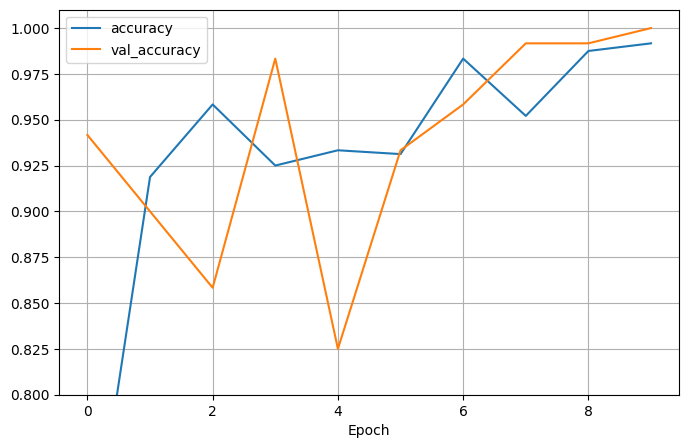

In [ ]:
# Convert the history dictionary to a Pandas dataframe and extract the accuracies
accuracies = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]

# Plot the accuracies
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.8, 1.01)
plt.xlabel('Epoch')
plt.show()

4/4 [==============================] - 2s 426ms/step


Text(737.5404040404039, 0.5, 'True labels')

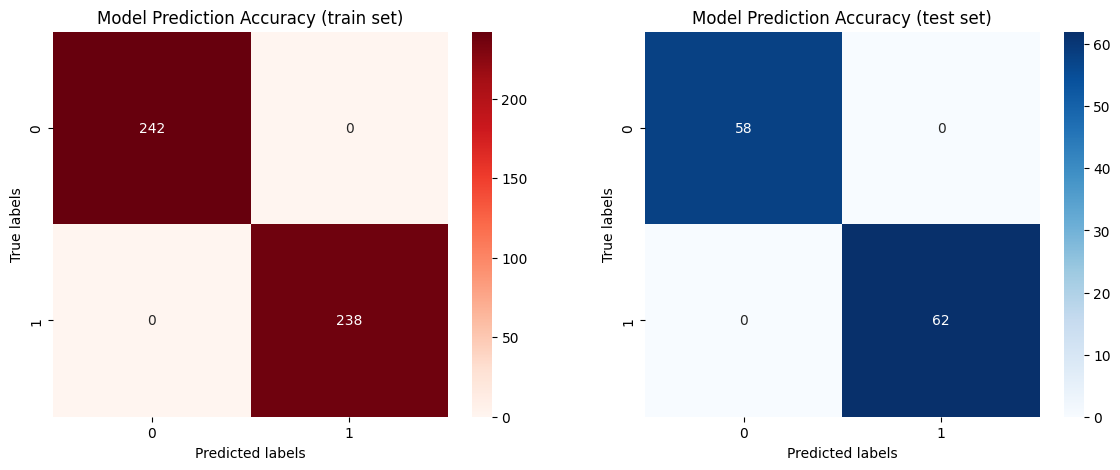

In [ ]:
y_pred = [int(i) for i in model.predict(X_train)]
y_pred_val = [int(i) for i in model.predict(X_val)]

# Compute the confusion matrix
cmTrain = confusion_matrix(y_train, y_pred)
cmTest = confusion_matrix(y_val, y_pred_val)

# Plotting the model accuracy
fig, axs = plt.subplots(ncols=2, figsize=(14, 5))


sns.heatmap(cmTrain, annot=True, cmap='Reds', fmt='g', ax=axs[0])
axs[0].set_title('Model Prediction Accuracy (in-sample set)')
axs[0].set_xlabel('Predicted labels')
axs[0].set_ylabel('True labels')

sns.heatmap(cmTest, annot=True, cmap='Blues', fmt='g', ax=axs[1])
axs[1].set_title('Model Prediction Accuracy (out-of-sample set)')
axs[1].set_xlabel('Predicted labels')
axs[1].set_ylabel('True labels')

In [ ]:
print("Out-of-sample Accuracy {0:.2f}%".format(100*accuracy_score(y_pred_val, y_val)))
print(classification_report(y_val, y_pred_val))

Accuracy 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        62

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



In [ ]:
print("In-sample Accuracy {0:.2f}%".format(100*accuracy_score(y_train,y_train)))
print(classification_report(y_pred,y_train))

In-sample Accuracy 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       242
           1       1.00      1.00      1.00       238

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480

